Curve Fitting: Fitting a LRC resonance curve to data
====================================================

Introduction
------------

In experimental physics we often have a set of data and a model of the data, 
in the form of
some function. Parameters of the model can be obtained by matching the model
to the data. In modern physics this is done by adjusting the parameters of the model
to minimise some statistic. This usually requires a computer program, since 
the dependence of the model on its parameters is seldom linear, or solvable analytically.

This process is usually referred to as "curve-fitting", and the statistic
to be determined is a "goodness of fit" value. (This is equivalent, 
under some conditions, to maximising the likelihood of the model).


In the series $LRC$ circuit, the response $V_R/V_0$ may be measured as a function of frequency $f$, where $V_R$ is the amplitude
of the voltage across the resistor and $V_0$ is the amplitude of the voltage across the whole circuit (i.e. the applied voltage).

The theory of the driven oscillator tells us that the expected response is
$$
\left|\frac{V_R}{V_0}\right|=\frac{R}{R_T}\frac{1}{\sqrt{1+Q^2\left(\frac{f}{f_0}-\frac{f_0}{f}\right)^2}}
$$
Here, $R$ is the value of the resistor, $R_T=R+R_X$ is the total resistance in the circuit ($R_X$ is mainly the resistance of the inductor at frequency $f$), $f_0$ is the resonance frequency and Q is the quality factor of the circuit.

The value of the inductance can be obtained from
$$
L=\frac{R_TQ}{2\pi f_0}
$$

What is measured is $V_0$ and its associated uncertainty $\delta V$, and at each frequency the voltage $V_R$ and its uncertainty $u$.

We fit the response function to the data to obtain $R_T$, $Q$ and $f_0$; then we can compute $L$ and its uncertainty.

The uncertainty in $|V_R/V|$ depends on the uncertainties of both quantities. Propagation of uncertainties yields
$$
u_{\text{tot}}=\frac{1}{V_0}\sqrt{u^2+\delta V^2\frac{V_R^2}{V_0^2}}=\frac{1}{V_0}\sqrt{u^2+\epsilon^2 V_R^2}
$$

Note that $\delta V/V_0$ is a constant, say $\epsilon$.

The fitting program
-------------------

Fitting a curve to data is usually done by adjusting a set of parameters that characterise the curve in order 
to minimise a goodness of fit variable. A typical goodness of fit variable is the "chi square" value,
$$
\chi^2=\sum_{i=1}^N\frac{(y_i-f(x_i;p))^2}{u_i^2}
$$
where $i$ runs over the data points, $y_i$ is the value of the data at $x_i$ and $f(x_i;p)$ is the
curve value which depends on $x_i$ and a set of parameters $\{p\}$. The data points are weighted by the
uncertainty $u_i$. You will notice that the sum of the squares of the residuals $y_i-f(x_i;p)$ is minimised;
the procedure is known as a weighted least-squares fit.  Most functions are not linear in the parameters.
No simple solution of the problem is known and the parameters must be adjusted iteratively in order to converge to a minimum.
This minimum might not be a global minimum, so a good set of starting parameters helps; a hand-drawn graph might help
in obtaining these. The scheme we will use in order to minimise the chi squared is the Levenberg-Marquard algorithm.

A detailed explanation of what this does and how to obtain and interpret the uncertainties is beyond the scope of these
notes. You are directed to a reference you should get to know, Numerical Recipes, *Press, Teukolsky, Vetterling, Flannery*,
Cambridge University Press.

In this notebook, we use `pylab` to plot and `curve_fit` from `scipy`, an implementation of the L-M algorithm,  to do the fit.

This is also a tutorial on the use of `numpy` and `matplotlib`.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
# convenience ...
sqrt=np.sqrt
pi=np.pi

For convenience, we enter the data into the code

In [4]:
#  data from LRC circuit measurement: [frequency, amplitude, uncertainty]
data=np.array([
    [ 2653, 1.08, 0.01 ],
    [ 2968, 1.28, 0.02 ],
    [ 3633, 1.92, 0.02 ],
    [ 4169, 2.86, 0.02 ],
    [ 4475, 3.70, 0.02 ],
    [ 4768, 4.90, 0.05 ],
    [ 5002, 6.05, 0.05 ],
    [ 5277, 7.45, 0.05 ],
    [ 5561, 7.80, 0.2 ],
    [ 5765, 7.00, 0.05 ],
    [ 6117, 5.55, 0.05 ],
    [ 6391, 4.55, 0.05 ],
    [ 6696, 3.76, 0.02 ],
    [ 7189, 2.95, 0.02 ],
    [ 7916, 2.24, 0.02 ],
    [ 8779, 1.75, 0.02 ],
    [ 9681, 1.45, 0.02 ],
    [ 10284, 1.27, 0.02 ]
    ])
# numpy allows us to pull out rows from the array, so we must transpose the data 
freq,vr,dvr=data.T

# uncertainty calculation
v0=10.0     # input to circuit
epsilon=0.05 # relative uncertainty in v0
uvr=sqrt(dvr*dvr+vr*vr*epsilon**2)/v0 #uncertainty in Vr

Define the LRC resonance function. This is a function of frequency, and depends on some parameters.
We will fit this to the data.

In [6]:
# define function to be fitted
def resonance(f,pR0,pf0,pQ):
    R=214.0
    return (R/pR0)/sqrt(1.0+pQ**2*(f/pf0-pf0/f)**2)

Now we define some initial values for the fit parameters. We will pass these to the fit routine in a list `p`. We will also accumulate the parameter names in a list which we will use when we output the results.

In [7]:
# the fit parameters: some starting values
R0=400.0
f0=4000.0
Q=1.0

p=[R0,f0,Q]
name=["R","f0","Q"]

We will plot the starting position to show how well, or badly, our initial guess of the parameters worked. So we
define a set of points for plotting the function and keep a copy of the initial resonance curve.

In [9]:
# for theory plot we need some frequencies
freqs=np.linspace(2000.0,11000.0,100)
initialplot=resonance(freqs,*p)
#print(p)

Now we use the Levenberg-Marquardt routine from `scipy` to do the fit. This returns some useful data:
* p2:   The final set of fit parameters
* cov:  An estimate of the covariance matrix

In [10]:
p2,cov=curve_fit(resonance, freq, vr/v0, p, sigma=uvr )#, absolute_sigma=True)
#print(p2)

The goodness of fit is defined via the $\chi^2$ value (known as the chi squared). We can use this and the covariance matrix to estimate the uncertainties in the parameters. This procedure is described in Numerical Recipes. 

Note that in this case, there is a strong (anti-)correlation between the variables $R_T$ and $Q$. If we calculate $L$ using these,
we must use the full covariance matrix in calculating the uncertainty in $L$, rather than just the diagonal elements.
It makes quite a difference.

Much of the code below is independent of the particular system being modelled, so you can use it in your own programs.  

In [11]:
# calculate final chi square
ymin=(vr/v0-resonance(freq, *p2))/uvr
chisq=np.sum(ymin*ymin)

dof=len(freq)-len(p)
# chisq, sqrt(chisq/dof) agrees with gnuplot
print( "Converged with chi squared ",chisq)
print( "degrees of freedom, dof ", dof)
print( "RMS of residuals (i.e. sqrt(chisq/dof)) ", sqrt(chisq/dof))
print ("Reduced chisq (i.e. variance of residuals) ", chisq/dof)
print()

# uncertainties are calculated as per gnuplot, "fixing" the result
# for non unit values of the reduced chisq.
# values at min match gnuplot
print( "Fitted parameters at minimum, with 68% C.I.:")
for i,pmin in enumerate(p2):
    print( "%2i %10s %12f +/- %10f"%(i,name[i],pmin,sqrt(cov[i,i])))#*sqrt(chisq/dof))
print()

print( "Correlation matrix")
# correlation matrix close to gnuplot
print( "               ",end='')
for i in range(len(p)): print( "%10s"%(name[i],),end='')
print()
for i in range(len(p2)):
    print( "%10s"%name[i],end='')
    for j in range(i+1):
        print("%10f"%(cov[i,j]/sqrt(cov[i,i]*cov[j,j]),),end='')
    print()
#cov=cov*(chisq/dof)
ap2=np.array(p2)
partials=np.outer(ap2,ap2)
#print partials
#print cov/partials
L=p2[0]*p2[2]/(2.0*np.pi*p2[1])
dL=L*np.sqrt(cov[0,0]/p2[0]**2+cov[1,1]/p2[1]**2+cov[2,2]/p2[2]**2)
dLfull=L*np.sqrt(np.sum(cov/partials))
print()
print( "L", L, "+/-", dL, "  (diagonal elements)")
print( "L", L, "+/-", dLfull, "  (full covariance matrix)"  )

Converged with chi squared  1.0862074498229717
degrees of freedom, dof  15
RMS of residuals (i.e. sqrt(chisq/dof))  0.2690981790874812
Reduced chisq (i.e. variance of residuals)  0.0724138299881981

Fitted parameters at minimum, with 68% C.I.:
 0          R   273.420928 +/-   2.197093
 1         f0  5486.691971 +/-   5.592488
 2          Q     4.530963 +/-   0.047889

Correlation matrix
                        R        f0         Q
         R  1.000000
        f0  0.023328  1.000000
         Q -0.914117  0.006076  1.000000

L 0.035936174878856086 +/- 0.00047852870808211885   (diagonal elements)
L 0.035936174878856086 +/- 0.00017068508419968716   (full covariance matrix)


Now we just have to plot the results. This is always a useful check to see if the fit "looks good".

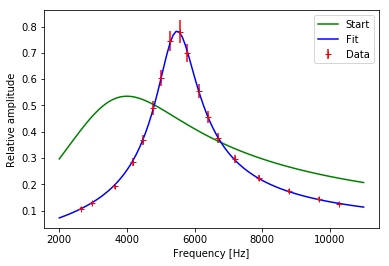

In [12]:
# Plot

# plot data
plt.errorbar(freq, vr/v0, yerr=uvr, fmt='r+', label="Data")
# plot fit
plt.plot(freqs, initialplot, 'g-', label="Start")
plt.plot(freqs, resonance(freqs,*p2), 'b-', label="Fit")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Relative amplitude")
#legend(("data","fit"))
plt.legend()
plt.show()

How do we interpret these results?

The fitted parameters are given with their standard uncertainties, assuming that the other parameters are fixed. These uncertainties
are only good estimates if the parameters are uncorrelated. In general, a more sophisticated approach is needed to evaluate reliable
uncertainties. But these are a good start.

The correlation matrix tells us how one parameter varies with another. The values are in $-1\le C\le 1$.
We see for instance that R and Q are strongly negatively correlated. Thus if R is increased, Q must decrease to compensate.
Care has to be used in using these uncertainties in propagation.

---

Monte Carlo methods for confidence limits
=========================================

Monte Carlo methods permit extraction of confidence limits on measured parameters
by sampling data sets from a synthetic distribution.

The Bootstrap method
--------------------

For the bootstrap method  we just draw $N$ sets of $N$ points from the existing data set, with replacement (points can be duplicated!), and get
$N$ sets of parameters by fitting. For each set we calculate $L$. Means, variances and standard deviations are then calculated
using this data set. Note that the results are quite similar to those calculated using the covariance matrix; note that
the uncertainty in $L$ automatically includes the correlations.

R 273.61199489893374 +/- 2.475950128060129
w 5486.48662228218 +/- 5.629498926816931
Q 4.53375638083585 +/- 0.051853189011242334
L 0.035981703147905324 +/- 0.00019518456807547698


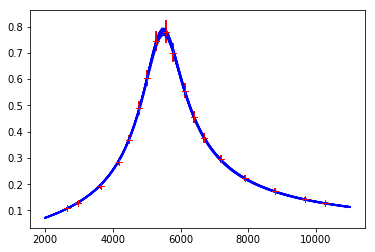

In [14]:
Ndata=len(freq)
vrel=vr/v0
savep=[]
for i in range(Ndata):
    p=[R0,f0,Q]
    indices=np.random.randint(Ndata,size=Ndata)
    #freqB=np.take(freq,indices)
    #vB=np.take(vrel,indices)
    #uB=np.take(uvr,indices)
    freqB=freq[indices]
    vB=vrel[indices]
    uB=uvr[indices]
    p2,cov=curve_fit(resonance, freqB, vB, p, sigma=uB)
    #print p2
    savep.append(p2)
    plt.errorbar(freqB, vB, yerr=uB, fmt='r+', label="Data")
    plt.plot(freqs, resonance(freqs,*p2), 'b-', label="Fit")

savep=np.array(savep)
#print np.shape(savep)
aL=savep[:,0]*savep[:,2]/(2.0*np.pi*savep[:,1])
print ('R', np.mean(savep[:,0]), "+/-", np.std(savep[:,0],ddof=1))
print( 'w', np.mean(savep[:,1]), "+/-", np.std(savep[:,1],ddof=1))
print( 'Q', np.mean(savep[:,2]), "+/-", np.std(savep[:,2],ddof=1))
print( 'L', np.mean(aL), "+/-", np.std(aL,ddof=1))

More compressed version of Bootstrap:

R 272.6617602709431 +/- 3.0810772417046803
w 5485.843189051405 +/- 6.026622249537033
Q 4.537492542388067 +/- 0.07048739765675661
L 0.03588792546688133 +/- 0.00020773140666389544


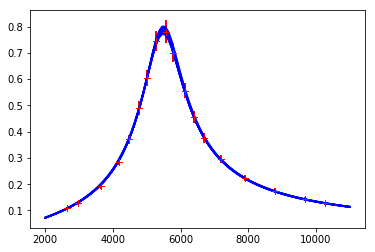

In [16]:
Ndata=len(freq)
vrel=vr/v0
def bootonce():
    p=[R0,f0,Q]
    indices=np.random.randint(Ndata,size=Ndata)
    freqB=freq[indices]
    vB=vrel[indices]
    uB=uvr[indices]
    p2,cov=curve_fit(resonance, freqB, vB, p, sigma=uB)
    plt.errorbar(freqB, vB, yerr=uB, fmt='r+', label="Data")
    plt.plot(freqs, resonance(freqs,*p2), 'b-', label="Fit")
    return p2

savep=[bootonce() for i in range(Ndata)]

savep=np.array(savep)
#print np.shape(savep)
aL=savep[:,0]*savep[:,2]/(2.0*np.pi*savep[:,1])
print( 'R', np.mean(savep[:,0]), "+/-", np.std(savep[:,0],ddof=1))
print( 'w', np.mean(savep[:,1]), "+/-", np.std(savep[:,1],ddof=1))
print( 'Q', np.mean(savep[:,2]), "+/-", np.std(savep[:,2],ddof=1))
print( 'L', np.mean(aL), "+/-", np.std(aL,ddof=1))

The Jacknife method
-------------------

Now try the jackknife method: create $N$ data sets of $N-1$ points by leaving out one point in each set. The means are calculated as
usual; the variance for quantity $x$ with mean $\bar x$ is
$$
\sigma_x^2=\frac{N-1}{N}\sum_{i=0}^{N-1}(x_i-\bar x)^2.
$$

R 273.4210256572071 +/- 2.605265385222392
w 5486.758741154262 +/- 5.554126723214433
Q 4.530986276833543 +/- 0.05769128570876667
L 0.03593569299282356 +/- 0.00017923379981408123


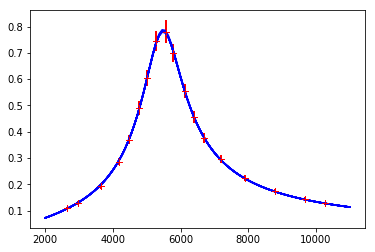

In [18]:
Ndata=len(freq)
sump=np.zeros(3)
vrel=vr/v0
savep=[]
for i in range(Ndata):
    p=[R0,f0,Q]
    indices=list(range(0,i))+list(range(i+1,Ndata))
    #print i,indices
    freqB=np.take(freq,indices)
    vB=np.take(vrel,indices)
    uB=np.take(uvr,indices)
    p2,cov=curve_fit(resonance, freqB, vB, p, sigma=uB)
    #print p2
    savep.append(p2)
    plt.errorbar(freqB, vB, yerr=uB, fmt='r+', label="Data")
    plt.plot(freqs, resonance(freqs,*p2), 'b-', label="Fit")

savep=np.array(savep)
#print Ndata, np.shape(savep)
aL=savep[:,0]*savep[:,2]/(2.0*np.pi*savep[:,1])
c=np.sqrt(float(Ndata-1))
print( 'R', np.mean(savep[:,0]),"+/-",  c*np.std(savep[:,0]))
print( 'w', np.mean(savep[:,1]), "+/-", c*np.std(savep[:,1]))
print( 'Q', np.mean(savep[:,2]), "+/-", c*np.std(savep[:,2]))
print( 'L', np.mean(aL), "+/-", c*np.std(aL))
#print savep[:,0]

---

Other methods
-------------

An alternate routine, `lmfit`, can enable us to get Bayesian estimates of the parameters distributions. This is explored in another notebook.

References
----------

Numerical Recipes, *Press, Teukolsky, Vetterling, Flannery*, Cambridge University Press.